In [1]:
import os
from pathlib import Path
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import timm
import cv2
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#set up dataset roots
DATA_ROOT = Path("data/tree")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"
VAL_DIR = DATA_ROOT / "val"

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
#CLAHE (Contrast-Limited Adaptive Histogram Equalization) transform is really good on tress since trees contrast greatly with the background, this "normalizes" the contrast making it more visible for the model

class CLAHETransform:
    """ Enhance image contrast with CLAHE"""

    def __init__(self, clip_limit = 2.0, tile_grid_size = (8,8)):
        self.clip_limit = clip_limit
        self.title_grid_szie = tile_grid_size

    #actual call we will use to apply the transforms
    def __call__(self, img):
        img_np = np.array(img)

        #create a LAB image since RGB does not work with CLAHE
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        #get luminance and a,b channels
        l,a,b = cv2.split(lab)

        #apply clahe on the luminance channel and merge it back
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.title_grid_szie)
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))

        finalImg = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

        return Image.fromarray(finalImg)

#create a letterbox resize to ensure aspect ratio is maintained
class LetterBoxResize:
    """ Resize an image with letterboxing to keep aspect ratio"""

    def __init__(self, size):
        self.size = size 
    
    def __call__(self, img):
        img.thumbnail((self.size, self.size), Image.Resampling.LANCZOS)

        #create a new bg, black for now
        new_img = Image.new("RGB", (self.size, self.size), (0,0,0))

        #paste the resized image into the center
        new_img.paste(img, ((self.size - img.size[0]) // 2,
                            (self.size - img.size[1]) // 2))
    
        return new_img
        
        


In [4]:
#set up transforms and dataloaders
train_transform = transforms.Compose([
    #custom augs
    LetterBoxResize(IMG_SIZE),
    CLAHETransform(clip_limit = 3.0),
    
    #torchvision augs
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.08, 0.08, 0.08, 0.02),

    #final prep
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    LetterBoxResize(IMG_SIZE),
    CLAHETransform(clip_limit = 3.0),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


train_ds_disk = ImageFolder(TRAIN_DIR, transform = train_transform)
val_ds_disk = ImageFolder(VAL_DIR, transform=val_transform)
test_ds_disk = ImageFolder(TEST_DIR, transform=val_transform)


Create a custom class for a DS that preloads everything in RAM so faster loading can happen (i hate windows)

In [5]:
class CachedDS(torch.utils.data.Dataset):
    """ A dataset wrapper that caches images so it loads faster"""

    def __init__(self, dataset):
        self.dataset = dataset
        #pre load all samples into a list
        print(f"Caching {len(dataset)} images into RAM")
        #prog bar so i dont tweak out
        self.samples = [dataset[i] for i in tqdm(range(len(dataset)))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return self.samples[idx]


train_ds = CachedDS(train_ds_disk)
val_ds = CachedDS(val_ds_disk)
test_ds = CachedDS(test_ds_disk)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers= NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers= NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers= NUM_WORKERS)


class_names = train_ds.dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Class Count:", num_classes)
print("Sizes of Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Caching 3850 images into RAM


  0%|          | 0/3850 [00:00<?, ?it/s]

Caching 482 images into RAM


  0%|          | 0/482 [00:00<?, ?it/s]

Caching 472 images into RAM


  0%|          | 0/472 [00:00<?, ?it/s]

Classes: ['Acer palmatum', 'Cedrus deodara', 'Celtis sinensis', 'Cinnamomum camphora (Linn) Presl', 'Elaeocarpus decipiens', 'Flowering cherry', 'Ginkgo biloba', 'Koelreuteria paniculata', 'Lagerstroemia indica', 'Liquidambar formosana', 'Liriodendron chinense', 'Magnolia grandiflora L', 'Magnolia liliflora Desr', 'Michelia chapensis', 'Osmanthus fragrans', 'Photinia serratifolia', 'Platanus', 'Prunus cerasifera f. atropurpurea', 'Salix babylonica', 'Sapindus saponaria', 'Styphnolobium japonicum', 'Triadica sebifera', 'Zelkova serrata']
Class Count: 23
Sizes of Train: 3850 Val: 482 Test: 472


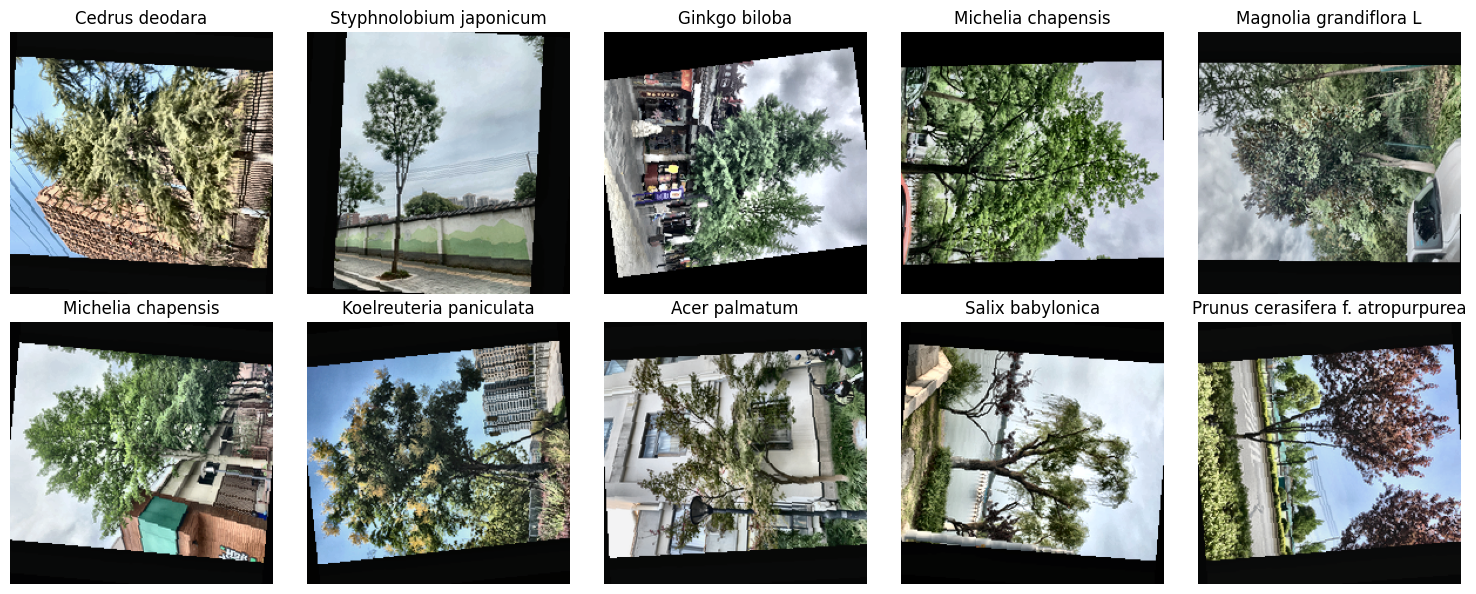

In [6]:
#show a bacth of the preprocessed images
def show_batch(loader, num_images = 10):
    #grab a single batch from the loader
    images, labels = next(iter(loader))

    #setup a plot
    fig, axes = (plt.subplots(num_images//5, 5, figsize =  (15,6)))
    axes = axes.flatten()

    #denorm
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_images):
        img = images[i].numpy().transpose((1,2,0)) #Change from (C, H, W) to (H, W, C)
        img = std * img + mean #denorm
        img = np.clip(img, 0, 1) #force vals between 0 and 1

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


show_batch(train_loader)

In [7]:
#utilize a mobile friendly model from timm, mobilenetV3

model = timm.create_model("mobilenetv3_large_100", pretrained = True, num_classes = num_classes)
model = model.to(DEVICE)

criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-1)

#have a schedler to decay LR over time
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 0.2, factor = 0.4)

In [8]:
def train_model(model, train_loader, val_loader, epochs):
    #setup a best acc so we can discard model weights that dont improve
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        r_loss = 0.0
        correct = 0
        total = 0


        #set a pbar so i dont tweak (again)
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)


            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            r_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

        #val phase
        val_acc, val_loss = eval_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {100.*correct/total:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved with acc: {:.2f}%".format(best_acc))
            
#def eval model func
def eval_model(model, loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 9
    with torch.no_grad():
        for images, labels in loader:
            images,labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _,predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    #returns acc and loss in that order
    return 100 * correct / total, val_loss / len(loader)

In [9]:
#train the model
train_model(model, train_loader, val_loader, NUM_EPOCHS)

Epoch 1/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1/20] | Train Acc: 48.16% | Val Acc: 44.40% | Val Loss: 1.9828
Best model saved with acc: 44.40%


Epoch 2/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2/20] | Train Acc: 73.30% | Val Acc: 48.88% | Val Loss: 2.0020
Best model saved with acc: 48.88%


Epoch 3/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3/20] | Train Acc: 83.35% | Val Acc: 71.89% | Val Loss: 1.0274
Best model saved with acc: 71.89%


Epoch 4/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4/20] | Train Acc: 86.49% | Val Acc: 74.13% | Val Loss: 0.9939
Best model saved with acc: 74.13%


Epoch 5/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5/20] | Train Acc: 84.57% | Val Acc: 68.23% | Val Loss: 1.1089


Epoch 6/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [6/20] | Train Acc: 92.18% | Val Acc: 82.89% | Val Loss: 0.5607
Best model saved with acc: 82.89%


Epoch 7/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [7/20] | Train Acc: 95.95% | Val Acc: 81.87% | Val Loss: 0.6430


Epoch 8/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [8/20] | Train Acc: 98.08% | Val Acc: 87.58% | Val Loss: 0.4676
Best model saved with acc: 87.58%


Epoch 9/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [9/20] | Train Acc: 98.99% | Val Acc: 87.37% | Val Loss: 0.4611


Epoch 10/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [10/20] | Train Acc: 99.27% | Val Acc: 86.97% | Val Loss: 0.4813


Epoch 11/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [11/20] | Train Acc: 99.51% | Val Acc: 89.61% | Val Loss: 0.4302
Best model saved with acc: 89.61%


Epoch 12/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [12/20] | Train Acc: 99.77% | Val Acc: 86.97% | Val Loss: 0.4466


Epoch 13/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [13/20] | Train Acc: 99.79% | Val Acc: 86.97% | Val Loss: 0.4512


Epoch 14/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [14/20] | Train Acc: 99.92% | Val Acc: 87.98% | Val Loss: 0.4270


Epoch 15/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [15/20] | Train Acc: 99.90% | Val Acc: 87.58% | Val Loss: 0.4338


Epoch 16/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [16/20] | Train Acc: 99.90% | Val Acc: 87.78% | Val Loss: 0.4155


Epoch 17/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [17/20] | Train Acc: 99.90% | Val Acc: 87.98% | Val Loss: 0.4245


Epoch 18/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [18/20] | Train Acc: 99.82% | Val Acc: 88.80% | Val Loss: 0.4185


Epoch 19/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [19/20] | Train Acc: 99.95% | Val Acc: 87.78% | Val Loss: 0.4411


Epoch 20/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch [20/20] | Train Acc: 99.90% | Val Acc: 88.19% | Val Loss: 0.4224



Classification Report:
                                   precision    recall  f1-score   support

                    Acer palmatum       0.25      0.85      0.39        20
                   Cedrus deodara       1.00      1.00      1.00        15
                  Celtis sinensis       0.77      0.43      0.56        23
 Cinnamomum camphora (Linn) Presl       0.92      0.83      0.87        29
            Elaeocarpus decipiens       0.76      0.76      0.76        21
                 Flowering cherry       1.00      0.46      0.63        13
                    Ginkgo biloba       0.81      0.61      0.69        28
          Koelreuteria paniculata       0.86      0.86      0.86        28
             Lagerstroemia indica       1.00      1.00      1.00         8
            Liquidambar formosana       0.94      0.85      0.89        20
            Liriodendron chinense       0.85      1.00      0.92        22
           Magnolia grandiflora L       0.93      0.96      0.94        26


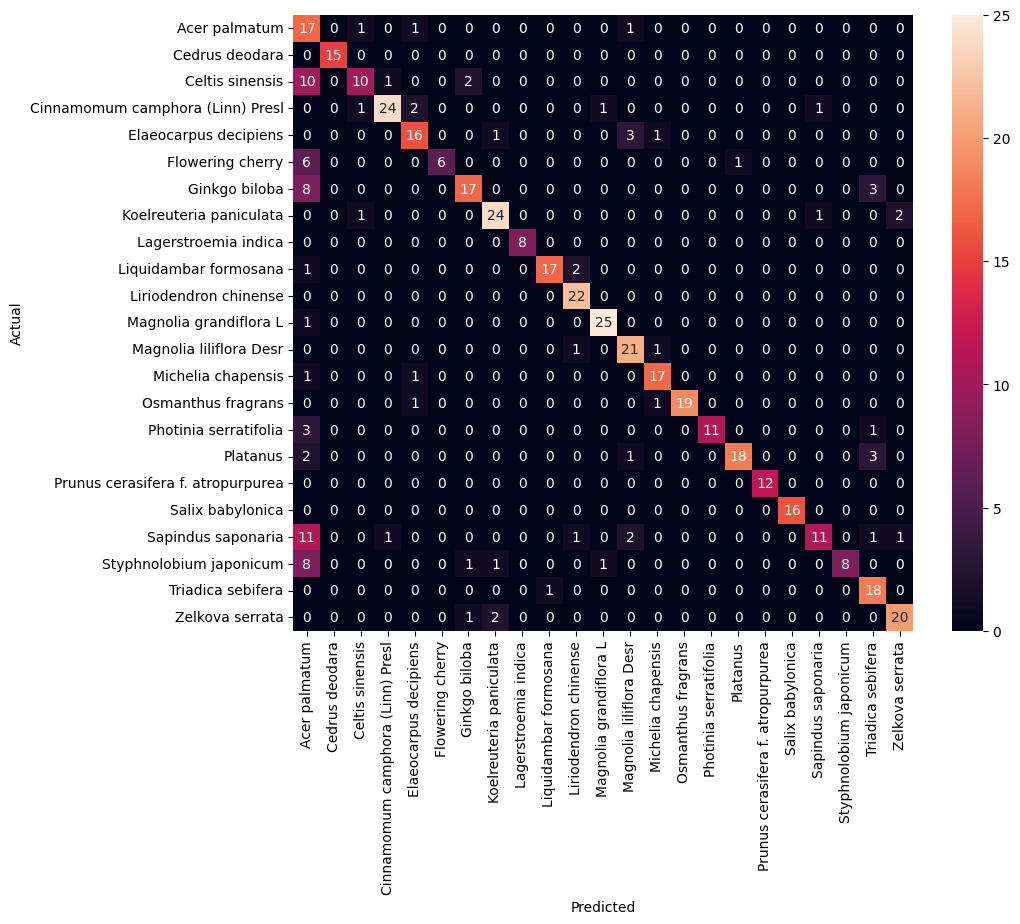

In [11]:
def final_report(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Visualization
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Run on test set
model.load_state_dict(torch.load("best_model.pth"))
final_report(model, test_loader)